# Exploration of the experiments

Analyses we care about:
* Plots for all the different experiments


In [106]:
import os 
import glob

import pandas as pd 
import numpy as np
import hydra
from omegaconf import DictConfig, OmegaConf
import yaml
from dataclasses import dataclass

import matplotlib.pyplot as plt

In [118]:
def list_experiments(path="data/results/", run_name="negotiations_2023-08-09/"):
    path_to_experiments = os.path.join(path, run_name)
    return [k for k in glob.glob(path_to_experiments+"*/")]

def get_yaml(path):
    with open(path, "r") as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

In [100]:
@dataclass
class NegotiationHistory:
    history_path: str
        
    def __post_init__(self):
        self.agent_1, self.agent_2 = self.extract_key_metadata_per_run()
        self.df = pd.read_csv(os.path.join(self.history_path, "processed_negotiation.csv"))
            
    def extract_agent_info(self, config):
        agent_model = config["generation_parameters"].split("/")[-1].split(".")[0]
        agent_communication_protocol = config["communication"].split("/")[-1].split(".")[0]
        agent_description = config["agent_description"].split("/")[-1].split(".")[0]
        return agent_model, agent_communication_protocol, agent_description

    def extract_key_metadata_per_run(self):
        config_path = os.path.join(self.history_path, ".hydra", "config.yaml")

        config = get_yaml(config_path)
        agent_1_model, agent_1_cp, agent_1_description = self.extract_agent_info(config["experiments"]["agent_1"])
        agent_2_model, agent_2_cp, agent_2_description = self.extract_agent_info(config["experiments"]["agent_2"])
        start_agent_index = config["experiments"]["negotiation_protocol"]["start_agent_index"]

        agent_1_start = True if start_agent_index == 0 else False
        agent_2_start = True if start_agent_index == 1 else False
        game_name = config["experiments"]["game"]["kwargs"].split("/")[-1].split(".")[0]
        agent_1 = Agent(agent_1_model, agent_1_cp, agent_1_description, agent_1_start, game_name)
        agent_2 = Agent(agent_2_model, agent_2_cp, agent_2_description, agent_2_start, game_name)

        return agent_1, agent_2
    
    def create_name(self):
        return f"""Agent 0: {self.agent_1.description} (starts: {self.agent_1.start}) vs. Agent 1: {self.agent_2.description} (starts: {self.agent_2.start})
{self.agent_1.communication_protocol} | {self.agent_2.communication_protocol}
{self.agent_1.model} | {self.agent_2.model}
"""


@dataclass
class Agent:
    model: str
    communication_protocol: str
    description: str
    start: bool
    game_style: str

In [108]:
hist = NegotiationHistory("data/runs/negotiations_2023-08-09/2023-08-10_19-49-39/")

In [109]:
runs = glob.glob("data/runs/negotiations_2023-08-09/*")

In [ ]:
for run in runs:
    history = NegotiationHistory(run)
    run_name = history.create_name()
    groups = history.df.groupby("agent_id")
    fig, ax = plt.subplots()

    for name, group in groups:
        x = group["round"]
        y = group["normalized_payoff"]
        
        ax.plot(x,y, label=name, alpha=0.5)
    plt.title(run_name)
    plt.legend()
    plt.show()



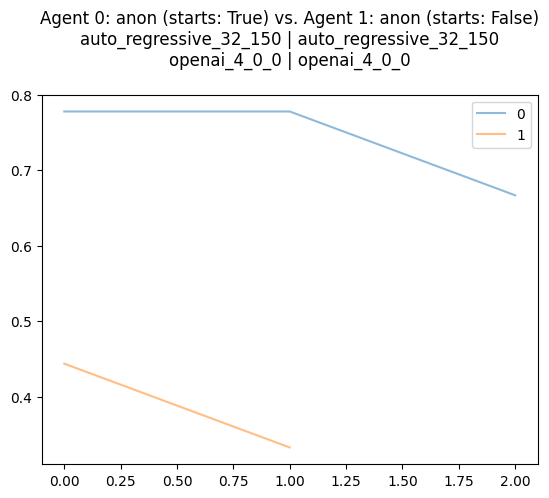

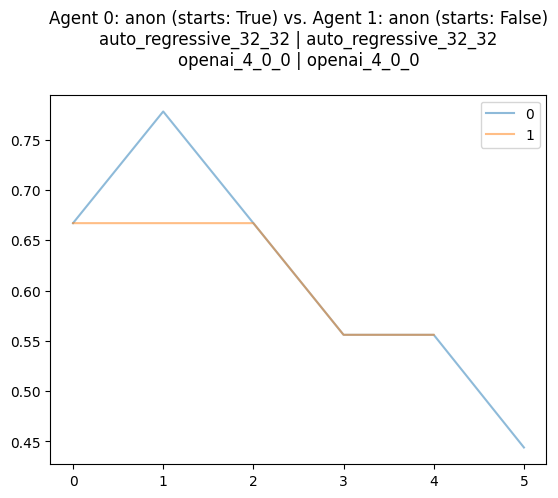

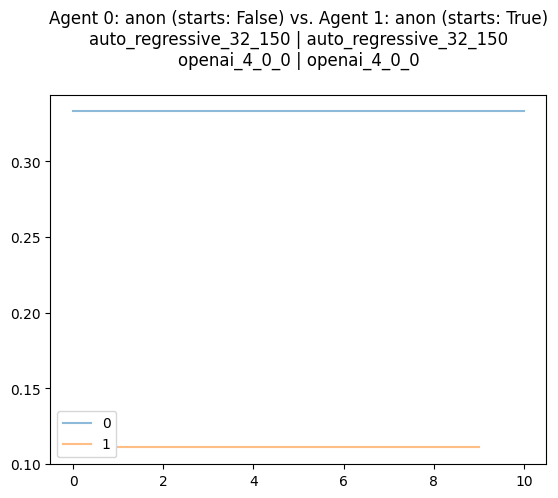

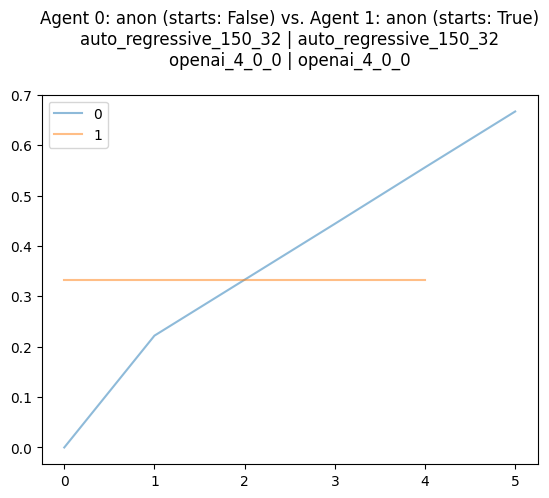

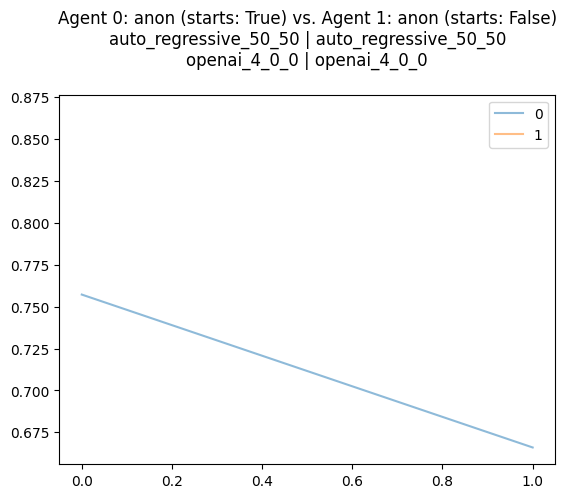

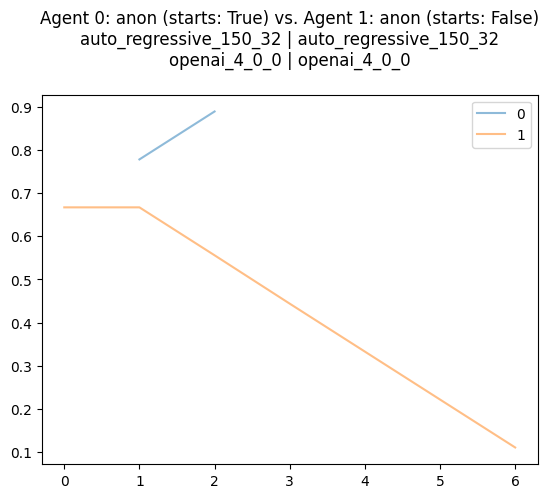

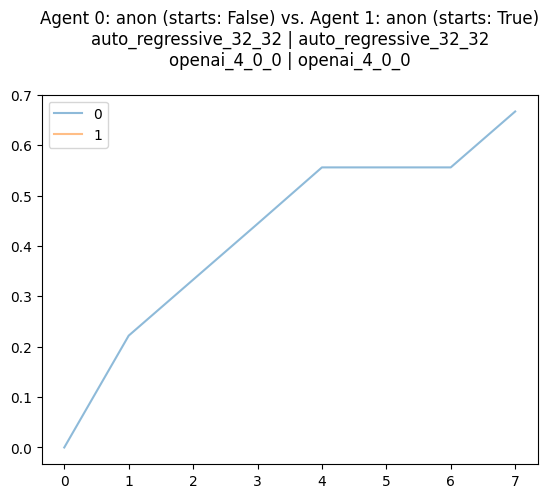

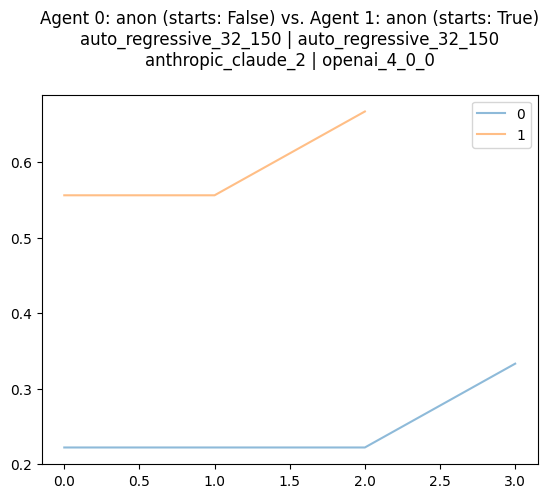

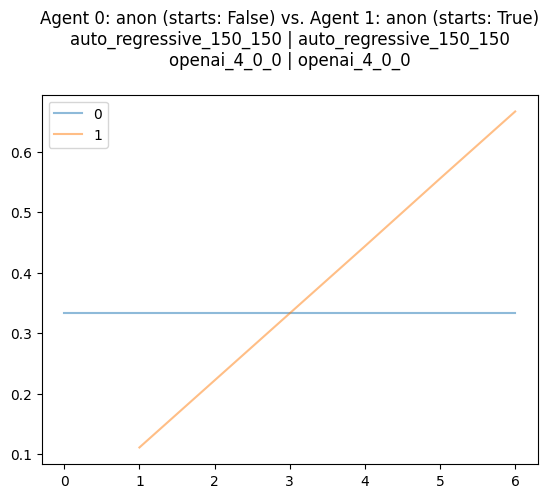

In [116]:
for run in runs:
    history = NegotiationHistory(run)
    run_name = history.create_name()
    groups = history.df.groupby("agent_id")
    fig, ax = plt.subplots()

    for name, group in groups:
        x = group["round"]
        y = group["normalized_payoff"]
        
        ax.plot(x,y, label=name, alpha=0.5)
    plt.title(run_name)
    plt.legend()
    plt.show()

